In [102]:
# ==============================================================================
# FLOOD RISK & POPULATION GROWTH ANALYSIS - HARRIS COUNTY CENSUS TRACTS
# ==============================================================================
# RESEARCH QUESTION: Are people moving away from flood-prone areas in Houston?
# HYPOTHESIS: Population growth is inversely correlated with flood risk
# GOAL: Understand which factors drive population growth (2010→2021)
# TYPE: Regression Problem - Historical Analysis
# OUTPUT: Feature importance showing how much flood risk influences growth patterns
# ==============================================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Set visualization style

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load and Inspect Data

Load the prepared CSV file that contains:

- Census tract identifiers
- **Population data (2010, 2015, 2021)** - to calculate growth rates
- **Flood hazard zones (Haz_major, Haz_max)** - PRIMARY FOCUS for hypothesis testing
- Elevation features (DEM_mean, min, max, std) - topography
- Flow accumulation metrics - drainage patterns
- Spatial features - geographic context

**Analysis Goal**: Test if flood-prone areas experienced lower population growth 2010-2021


In [103]:
# Load the prepared dataset
# This CSV was created from the census crosswalk notebook (02_census_crosswalk.ipynb)
# It contains harmonized population data on 2020 boundaries with ~782 tracts
df = pd.read_csv("../data/processed/census/Harris_Census_ML_Complete.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nColumn names:")
print(df.columns.tolist())

print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nBasic statistics:")
print(df.describe())

# IMPORTANT: Decode Haz_major from numeric to categorical
print(f"\n⚠️  Converting Haz_major from numeric codes to flood zone names...")
print(f"Original Haz_major values: {df['Haz_major'].unique()}")

# FEMA flood hazard zone mapping (based on your shapefile metadata)
haz_mapping = {
    0.0: 'Minimal Risk',    # Area of minimal flood hazard (outside 500-year floodplain)
    1.0: '0.2% Annual',     # 0.2% annual chance flood hazard (500-year flood)
    2.0: 'Floodway',        # Regulatory floodway (high velocity, strictest regulations)
    3.0: 'Riverine/Coastal',# Riverine floodway shown in coastal zone
    4.0: 'Levee Protected', # Area with reduced risk due to levee
}

df['Haz_zone'] = df['Haz_major'].map(haz_mapping)

# Handle any unmapped values
if df['Haz_zone'].isna().any():
    print(f"⚠️  Warning: {df['Haz_zone'].isna().sum()} tracts have unmapped Haz_major values")
    df['Haz_zone'] = df['Haz_zone'].fillna('Unknown')

print(f"\n✅ Decoded flood zones:")
print(df['Haz_zone'].value_counts().sort_index())
print(f"\nFlood risk ranking (highest to lowest):")
print(f"  1. Floodway (2.0) - Most dangerous, strictest regulations")
print(f"  2. Riverine/Coastal (3.0) - High risk in coastal areas")
print(f"  3. 0.2% Annual (1.0) - Moderate risk (500-year flood)")
print(f"  4. Levee Protected (4.0) - Reduced risk due to infrastructure")
print(f"  5. Minimal Risk (0.0) - Lowest risk")

Dataset shape: (1093, 43)

First few rows:
   +OID_  FID_1  STATEFP  COUNTYFP  TRACTCE        GEOID     NAME  \
0      1      1       48       201   421700  48201421700  4217.00   
1      2      2       48       201   233105  48201233105  2331.05   
2      3      3       48       201   341800  48201341800  3418.00   
3      4      4       48       201   252201  48201252201  2522.01   
4      5      5       48       201   451700  48201451700  4517.00   

               NAMELSAD  MTFCC FUNCSTAT  ...  population_2015  \
0     Census Tract 4217  G5020        S  ...      4597.000000   
1  Census Tract 2331.05  G5020        S  ...      4878.576156   
2     Census Tract 3418  G5020        S  ...      1770.000000   
3  Census Tract 2522.01  G5020        S  ...       973.436573   
4     Census Tract 4517  G5020        S  ...      3947.000000   

   population_2010  growth_2010_2021_abs  growth_2010_2021_pct  \
0      4817.000000           -204.000000             -4.235001   
1      4800.095005 

## 2. Create Target Variable (Y)

**Target**: % Population Change from 2010 to 2021

Formula: `((pop_2021 - pop_2010) / pop_2010) * 100`

This represents the percentage growth or decline over the ~11 year period.


Dataset shape after cleaning: (1052, 45)

Target variable statistics:
count    1052.000000
mean       20.707091
std        44.102949
min       -73.891261
25%        -6.231167
50%         9.450037
75%        33.344319
max       197.582387
Name: pop_change_pct, dtype: float64


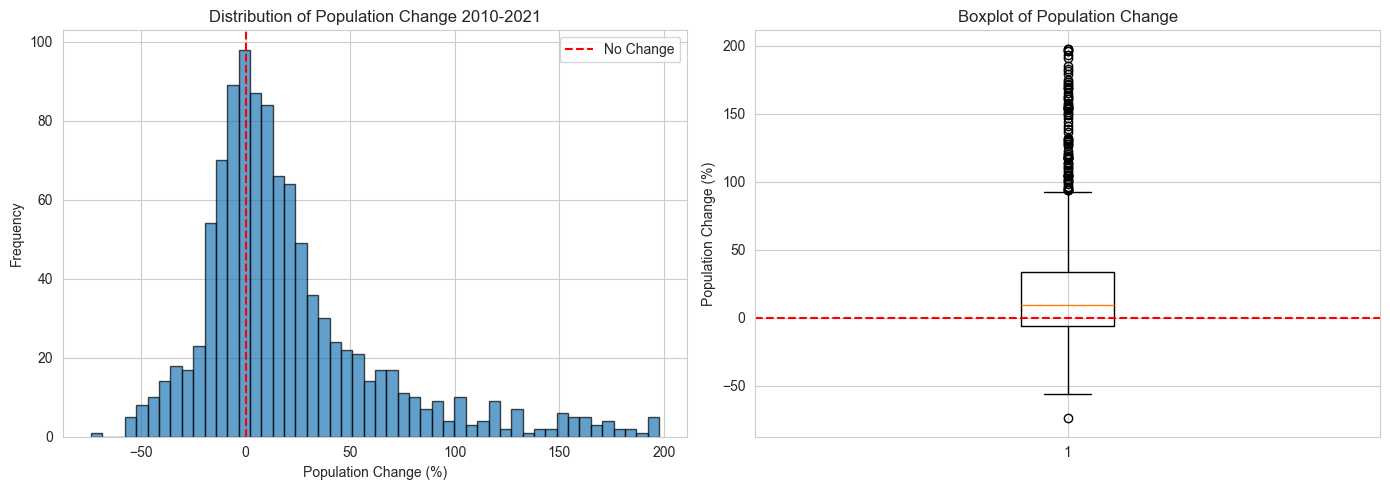


Growth categories:
  Declining (< -5%): 280 tracts
  Stable (-5% to 5%): 172 tracts
  Growing (> 5%): 600 tracts


In [104]:
# The dataset already has growth_2010_2021_pct calculated from crosswalk harmonization
# We'll use it as our target variable (Y)
df["pop_change_pct"] = df["growth_2010_2021_pct"]

# Handle edge cases
# Remove tracts with zero population in 2010 (division by zero)
df = df[df["population_2010"] > 0].copy()

# Remove extreme outliers to focus on typical growth patterns
# Extreme values (>200% growth) are likely from tract boundary changes or data errors
# Keep moderate outliers to preserve real growth variation
df = df[(df["pop_change_pct"] > -90) & (df["pop_change_pct"] < 200)].copy()

print(f"Dataset shape after cleaning: {df.shape}")
print(f"\nTarget variable statistics:")
print(df["pop_change_pct"].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["pop_change_pct"], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Population Change (%)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Population Change 2010-2021")
axes[0].axvline(0, color="red", linestyle="--", label="No Change")
axes[0].legend()

axes[1].boxplot(df["pop_change_pct"])
axes[1].set_ylabel("Population Change (%)")
axes[1].set_title("Boxplot of Population Change")
axes[1].axhline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

print(f"\nGrowth categories:")
print(f"  Declining (< -5%): {len(df[df['pop_change_pct'] < -5])} tracts")
print(
    f"  Stable (-5% to 5%): {len(df[(df['pop_change_pct'] >= -5) & (df['pop_change_pct'] <= 5)])} tracts"
)
print(f"  Growing (> 5%): {len(df[df['pop_change_pct'] > 5])} tracts")

## 3. Define Feature Sets (X)

**Feature Categories:**

1. **Flood Risk Features:**

   - `pct_in_AE`: % of tract in high-risk AE flood zone
   - `pct_in_X`: % of tract in low-risk X zone (outside 500-year floodplain)
   - `pct_in_VE`: % in coastal high velocity zone (if applicable)
   - `pct_in_floodway`: % in regulatory floodway

2. **Elevation & Topography:**

   - `elev_mean`: Mean elevation (meters)
   - `elev_min`: Minimum elevation
   - `elev_max`: Maximum elevation
   - `elev_std`: Elevation standard deviation (terrain roughness)
   - `slope_mean`: Mean terrain slope
   - `slope_max`: Maximum slope
   - `pct_low_slope`: % of area with slope < 2 degrees (flat/flood-prone)

3. **Hydrological:**

   - `dist_water_m`: Distance to nearest water body (meters)
   - `flowacc_mean`: Mean flow accumulation (drainage potential)
   - `rem_mean`: Relative Elevation Model value (height above nearest drainage)

4. **Baseline Demographics:**

   - `pop_2010`: Initial population (baseline)
   - `pop_density_2010`: Population density in 2010 (people/sq km)
   - `area_sq_km`: Tract area

5. **Spatial Features (optional):**
   - `centroid_lat`: Latitude of tract centroid
   - `centroid_lon`: Longitude of tract centroid
   - `dist_to_downtown_km`: Distance to downtown Houston


In [105]:
# Define feature columns based on Harris_Census_ML_Complete.csv
# NOTE: Removed 'population_2010' to avoid data leakage (it's used to calculate target)
# NOTE: Removed 'area_sq_km' and 'pop_density_2010' - they dominate the model
feature_cols = [
    # FLOOD RISK FEATURES (PRIMARY FOCUS FOR HYPOTHESIS TESTING)
    # Will use ONE-HOT ENCODING for Haz_zone below
    # Elevation & topography (correlated with flood risk)
    "DEM_mean",       # Mean elevation - lower = more flood-prone
    "DEM_min",        # Minimum elevation
    "DEM_max",        # Maximum elevation
    "DEM_std",        # Terrain roughness (flat areas flood more)
    # Hydrological/Flow (drainage and water accumulation)
    "FloAc_mean",     # Mean flow accumulation
    "FloAc_std",      # Flow accumulation variability
    "FlowAc_max",     # Maximum flow accumulation (drainage channels)
    "FloDir_mea",     # Mean flow direction
    # Tract characteristics (but NOT area or density)
    "AWATER",              # Water area within tract
    # Spatial features (location effects)
    "INTPTLAT",       # Latitude of tract centroid
    "INTPTLON",       # Longitude of tract centroid
]

# Check which features are actually available
available_features = [col for col in feature_cols if col in df.columns]
missing_features = [col for col in feature_cols if col not in df.columns]

print(f"Available features ({len(available_features)}): {available_features}")
print(f"\nMissing features ({len(missing_features)}): {missing_features}")

# Handle missing Haz_zone BEFORE creating features
print(f"\n⚠️  Handling missing flood zone data...")
missing_haz = df['Haz_zone'].isna().sum()
if missing_haz > 0:
    print(f"   {missing_haz} tracts have missing Haz_zone - filling with 'Unknown'")
    df['Haz_zone'] = df['Haz_zone'].fillna('Unknown')

# Remove tracts with missing target variable
df_clean = df[df['pop_change_pct'].notna()].copy()
print(f"\n✅ Clean dataset: {len(df_clean)} tracts (removed {len(df) - len(df_clean)} with missing growth data)")

# ONE-HOT ENCODE flood zones (convert categorical to dummy variables)
print(f"\n🔧 Creating one-hot encoding for flood zones...")
flood_dummies = pd.get_dummies(df_clean['Haz_zone'], prefix='FloodZone', drop_first=True)
print(f"Created dummy variables: {flood_dummies.columns.tolist()}")

# Combine original features with flood zone dummies
X = pd.concat([df_clean[available_features].copy(), flood_dummies], axis=1)
y = df_clean["pop_change_pct"].copy()

# Update available_features to include flood dummies
available_features = X.columns.tolist()

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Final features ({len(available_features)}): {available_features}")
print(f"Target variable shape: {y.shape}")

# Check for missing values in features
print(f"\nMissing values in features:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
    print("\n⚠️  Filling missing values with column medians...")
    X = X.fillna(X.median())


Available features (11): ['DEM_mean', 'DEM_min', 'DEM_max', 'DEM_std', 'FloAc_mean', 'FloAc_std', 'FlowAc_max', 'FloDir_mea', 'AWATER', 'INTPTLAT', 'INTPTLON']

Missing features (0): []

⚠️  Handling missing flood zone data...

✅ Clean dataset: 1052 tracts (removed 0 with missing growth data)

🔧 Creating one-hot encoding for flood zones...
Created dummy variables: ['FloodZone_Floodway', 'FloodZone_Levee Protected', 'FloodZone_Minimal Risk', 'FloodZone_Riverine/Coastal']

Final feature matrix shape: (1052, 15)
Final features (15): ['DEM_mean', 'DEM_min', 'DEM_max', 'DEM_std', 'FloAc_mean', 'FloAc_std', 'FlowAc_max', 'FloDir_mea', 'AWATER', 'INTPTLAT', 'INTPTLON', 'FloodZone_Floodway', 'FloodZone_Levee Protected', 'FloodZone_Minimal Risk', 'FloodZone_Riverine/Coastal']
Target variable shape: (1052,)

Missing values in features:


## 4. Exploratory Data Analysis (EDA)

Understand relationships between features and target variable.


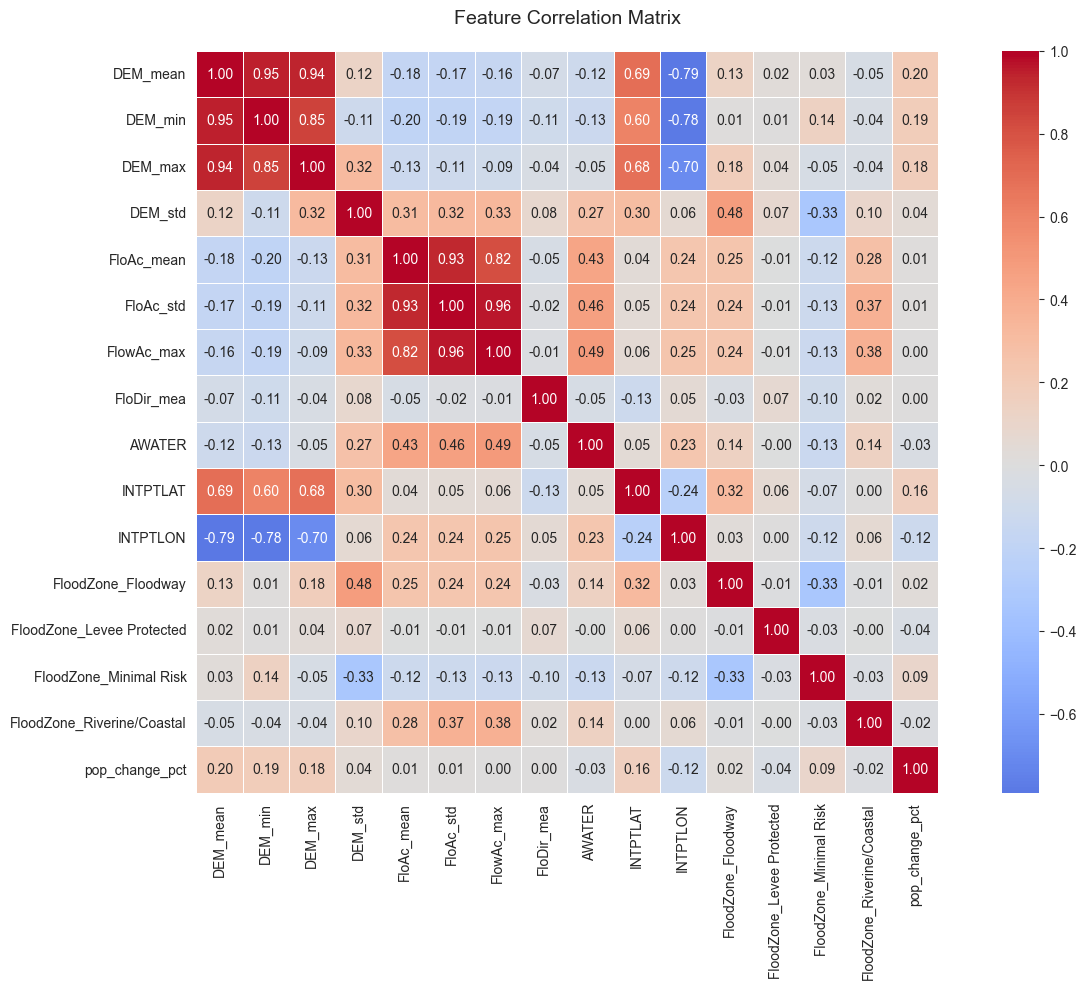


Correlation with population change (sorted by absolute value):
DEM_mean                      0.196392
DEM_min                       0.187095
DEM_max                       0.178048
INTPTLAT                      0.156109
INTPTLON                      0.119254
FloodZone_Minimal Risk        0.091875
DEM_std                       0.044447
FloodZone_Levee Protected     0.038388
AWATER                        0.029361
FloodZone_Floodway            0.022258
FloodZone_Riverine/Coastal    0.017694
FloAc_std                     0.009109
FloAc_mean                    0.008762
FlowAc_max                    0.004773
FloDir_mea                    0.004080
Name: pop_change_pct, dtype: float64


In [106]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_data = pd.concat([X, y], axis=1)
corr_matrix = correlation_data.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
)
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Show correlations with target variable
print("\nCorrelation with population change (sorted by absolute value):")
target_corr = (
    corr_matrix["pop_change_pct"]
    .drop("pop_change_pct")
    .abs()
    .sort_values(ascending=False)
)
print(target_corr)

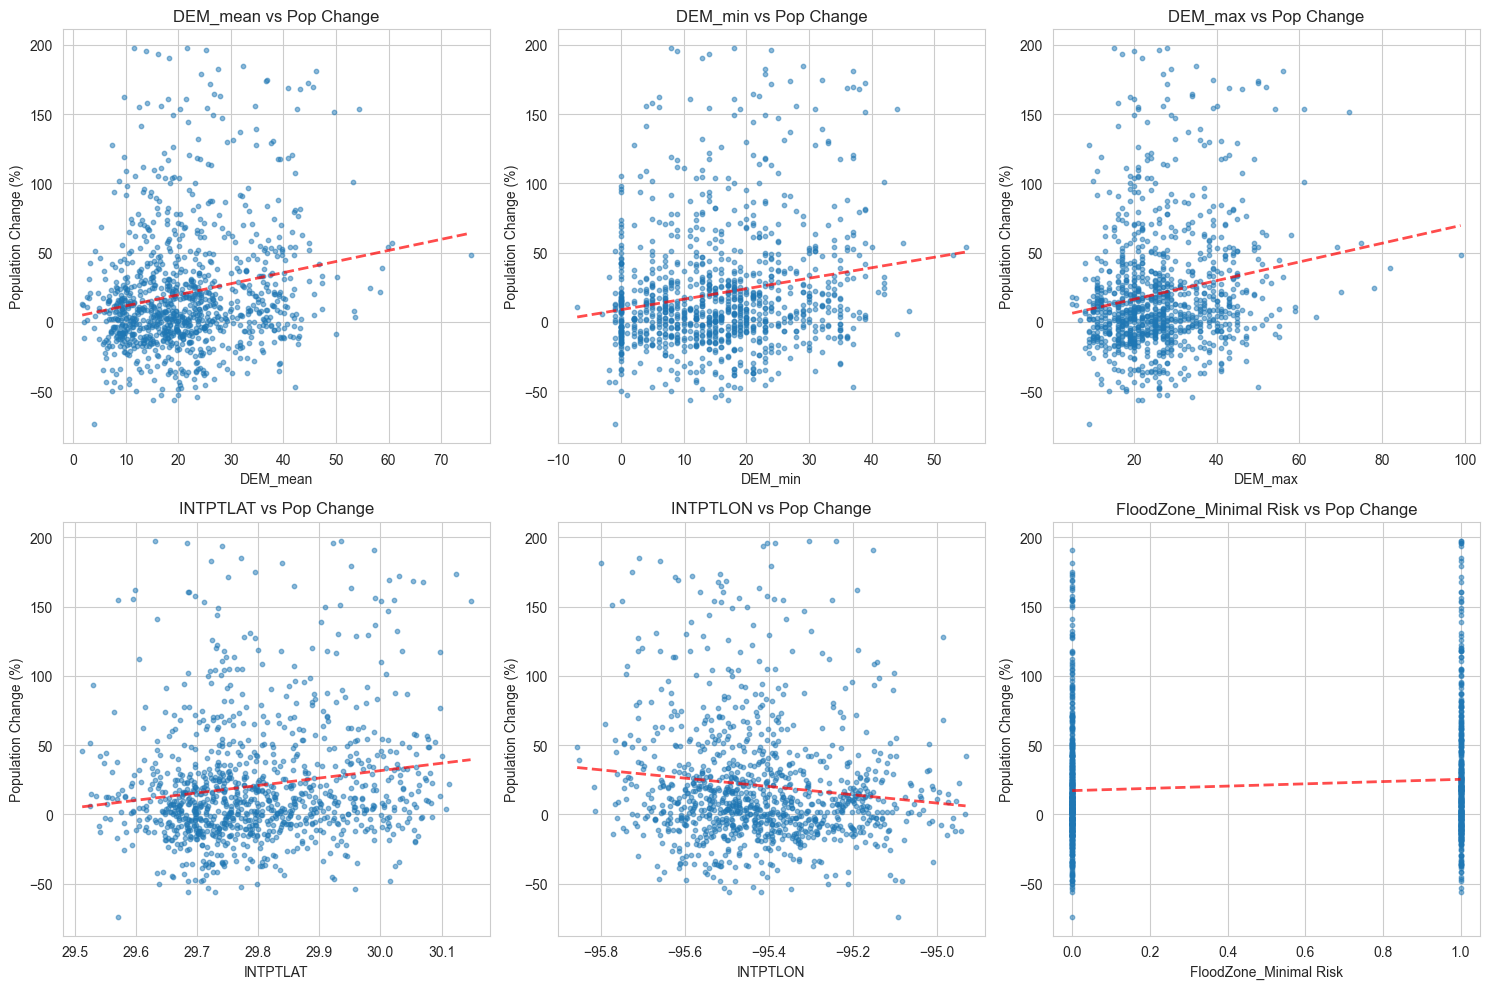

In [107]:
# Scatter plots of top correlated features
top_features = target_corr.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(X[feature], y, alpha=0.5, s=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Population Change (%)")
    axes[i].set_title(f"{feature} vs Pop Change")

    # Add trend line
    z = np.polyfit(X[feature], y, 1)
    p = np.poly1d(z)
    axes[i].plot(
        X[feature].sort_values(),
        p(X[feature].sort_values()),
        "r--",
        linewidth=2,
        alpha=0.7,
    )

plt.tight_layout()
plt.show()

## 5. Data Preparation & Train-Test Split

Split data into training (75%) and testing (25%) sets.


In [108]:
# Train-test split (75-25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Training set size: {X_train.shape[0]} tracts")
print(f"Testing set size: {X_test.shape[0]} tracts")
print(f"Number of features: {X_train.shape[1]}")

# Feature scaling (important for some algorithms)
# Tree-based models don't require scaling, but linear models do
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData prepared for modeling!")

Training set size: 789 tracts
Testing set size: 263 tracts
Number of features: 15

Data prepared for modeling!


## 6. Model Training - Gradient Boosting Regressor

Train a Gradient Boosting Regressor to predict population growth.


In [109]:
# Initialize model - Gradient Boosting Regressor
# HEAVILY REGULARIZED to prevent overfitting
model = GradientBoostingRegressor(
    n_estimators=50,       # Drastically reduced
    learning_rate=0.1,     
    max_depth=2,           # Very shallow trees (was 3)
    min_samples_split=50,  # Much higher (was 20)
    min_samples_leaf=25,   # Much higher (was 10)
    subsample=0.7,         # Use only 70% of data per tree
    max_features='sqrt',   # Only use sqrt(n) features per split
    random_state=42
)

print("Training HEAVILY REGULARIZED Gradient Boosting Regressor...\n")
print("  Target: Reduce overfitting (Test R² should be within 0.1 of Train R²)")

# Train the model
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Training Results:")
print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
print(f"  Train MAE: {train_mae:.2f}% | Test MAE: {test_mae:.2f}%")
print(f"  Test RMSE: {test_rmse:.2f}%")

# Diagnostic check
overfitting_gap = train_r2 - test_r2
print(f"\n📊 Model Diagnostic:")
if test_r2 < 0:
    print(f"   ❌ CRITICAL: Negative Test R² ({test_r2:.3f}) - model worse than baseline!")
    print(f"      Predicting the mean would be better. Check data quality.")
elif overfitting_gap > 0.3:
    print(f"   ⚠️  SEVERE OVERFITTING: Gap = {overfitting_gap:.3f}")
elif overfitting_gap > 0.1:
    print(f"   ⚠️  MODERATE OVERFITTING: Gap = {overfitting_gap:.3f}")
else:
    print(f"   ✅ GOOD FIT: Gap = {overfitting_gap:.3f}")
print()

Training HEAVILY REGULARIZED Gradient Boosting Regressor...

  Target: Reduce overfitting (Test R² should be within 0.1 of Train R²)
Training Results:
  Train R²: 0.1511 | Test R²: 0.0142
  Train MAE: 28.37% | Test MAE: 32.22%
  Test RMSE: 45.70%

📊 Model Diagnostic:
   ⚠️  MODERATE OVERFITTING: Gap = 0.137




GRADIENT BOOSTING REGRESSOR - PERFORMANCE SUMMARY
Training R²:       0.1511
Test R²:           0.0142
Test MAE:          32.22%
Test RMSE:         45.70%
Training samples:  789
Test samples:      263


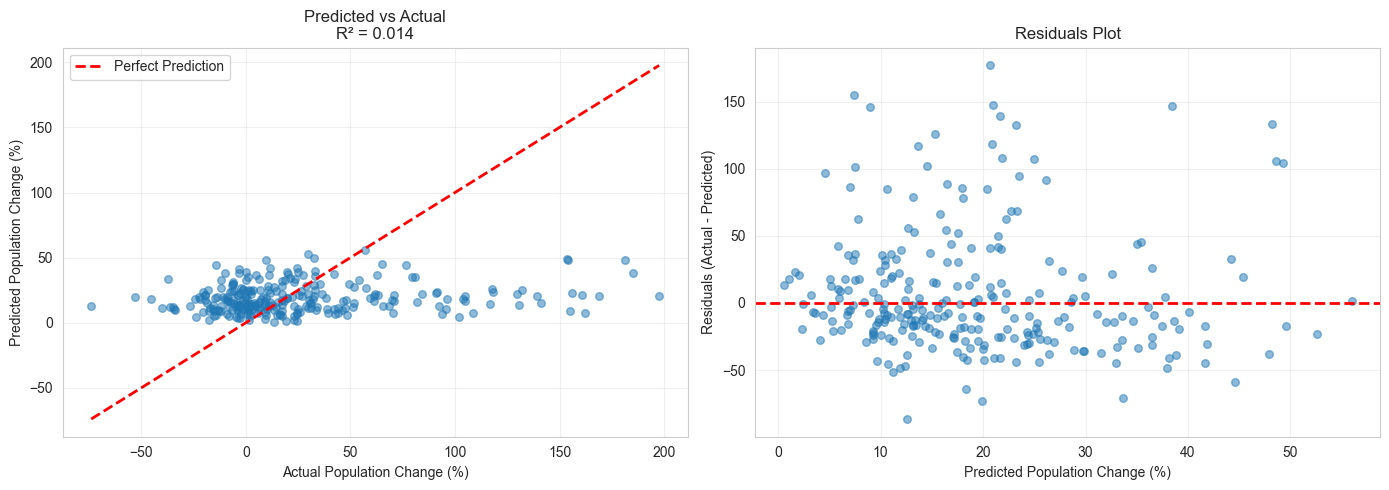

In [110]:
# Display model performance summary
print("\n" + "=" * 70)
print("GRADIENT BOOSTING REGRESSOR - PERFORMANCE SUMMARY")
print("=" * 70)
print(f"Training R²:       {train_r2:.4f}")
print(f"Test R²:           {test_r2:.4f}")
print(f"Test MAE:          {test_mae:.2f}%")
print(f"Test RMSE:         {test_rmse:.2f}%")
print(f"Training samples:  {len(X_train)}")
print(f"Test samples:      {len(X_test)}")
print("=" * 70)

# Visualize performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=30)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
axes[0].set_xlabel("Actual Population Change (%)")
axes[0].set_ylabel("Predicted Population Change (%)")
axes[0].set_title(f"Predicted vs Actual\nR² = {test_r2:.3f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, s=30)
axes[1].axhline(0, color="red", linestyle="--", lw=2)
axes[1].set_xlabel("Predicted Population Change (%)")
axes[1].set_ylabel("Residuals (Actual - Predicted)")
axes[1].set_title("Residuals Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [111]:
# ================================
# 6b. Model Comparison (Interpretable)
# ================================
from sklearn.linear_model import ElasticNet
from sklearn.inspection import permutation_importance

print("\nRunning interpretable model comparison...")

models = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    ),
    "Ridge": Ridge(alpha=10.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=10000, random_state=42),
}

results = []
permutation_importances = {}

# Use scaled features for linear models; raw for tree models
linear_keys = {"Ridge", "Lasso", "ElasticNet"}

for name, mdl in models.items():
    print(f"\n>>> Training {name}...")
    if name in linear_keys:
        mdl.fit(X_train_scaled, y_train)
        y_pred_tr = mdl.predict(X_train_scaled)
        y_pred_te = mdl.predict(X_test_scaled)
        X_te_for_perm = X_test_scaled
        feature_names = X.columns.tolist()
    else:
        mdl.fit(X_train, y_train)
        y_pred_tr = mdl.predict(X_train)
        y_pred_te = mdl.predict(X_test)
        X_te_for_perm = X_test
        feature_names = X.columns.tolist()

    tr_r2 = r2_score(y_train, y_pred_tr)
    te_r2 = r2_score(y_test, y_pred_te)
    te_mae = mean_absolute_error(y_test, y_pred_te)
    te_rmse = np.sqrt(mean_squared_error(y_test, y_pred_te))

    results.append({
        "Model": name,
        "Train_R2": tr_r2,
        "Test_R2": te_r2,
        "Test_MAE": te_mae,
        "Test_RMSE": te_rmse,
    })

    # Model-agnostic permutation importance (robust, comparable)
    print(f"   Computing permutation importance for {name}...")
    perm = permutation_importance(mdl, X_te_for_perm, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": perm.importances_mean,
        "Std": perm.importances_std,
    }).sort_values("Importance", ascending=False)
    permutation_importances[name] = imp_df

# Summarize results
results_df = pd.DataFrame(results).sort_values("Test_R2", ascending=False)
print("\nModel Performance Summary (sorted by Test R²):")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model based on Test R²: {best_model_name}")

# Show top features for each model (permutation importance)
for name, imp in permutation_importances.items():
    print("\n" + "-"*60)
    print(f"Top 10 features by permutation importance: {name}")
    print(imp.head(10).to_string(index=False))

# Replace current 'model' with best performing for downstream analysis
model = models[best_model_name]
if best_model_name in linear_keys:
    model.fit(X_train_scaled, y_train)
    final_pred_test = model.predict(X_test_scaled)
else:
    model.fit(X_train, y_train)
    final_pred_test = model.predict(X_test)

test_r2 = r2_score(y_test, final_pred_test)
test_mae = mean_absolute_error(y_test, final_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, final_pred_test))
print(f"\nUpdated downstream metrics using {best_model_name}:")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.2f}%")
print(f"  Test RMSE: {test_rmse:.2f}%")



Running interpretable model comparison...

>>> Training GradientBoosting...
   Computing permutation importance for GradientBoosting...
   Computing permutation importance for GradientBoosting...

>>> Training RandomForest...

>>> Training RandomForest...
   Computing permutation importance for RandomForest...
   Computing permutation importance for RandomForest...

>>> Training Ridge...
   Computing permutation importance for Ridge...

>>> Training Lasso...
   Computing permutation importance for Lasso...

>>> Training ElasticNet...
   Computing permutation importance for ElasticNet...

Model Performance Summary (sorted by Test R²):
           Model  Train_R2  Test_R2  Test_MAE  Test_RMSE
           Lasso    0.0549   0.0475   31.1580    44.9242
      ElasticNet    0.0549   0.0464   31.1805    44.9499
           Ridge    0.0548   0.0448   31.2139    44.9871
    RandomForest    0.5993   0.0389   32.0953    45.1266
GradientBoosting    0.3482   0.0229   32.1462    45.5009

Best model bas

In [112]:
# ================================
# 6b. Final Selected Model: RandomForest
# ================================
from sklearn.ensemble import RandomForestRegressor

# Tuned RandomForest based on your results
model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
)

print("Training final RandomForest model...")
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Final RandomForest Performance:")
print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.2f}% | Test RMSE: {test_rmse:.2f}%")

# Feature importance (built-in) + permutation importance for robustness
from sklearn.inspection import permutation_importance

rf_builtin_importance = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'Importance': model.feature_importances_,
}).sort_values('Importance', ascending=False)

perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
rf_perm_importance = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'Importance': perm.importances_mean,
    'Std': perm.importances_std,
}).sort_values('Importance', ascending=False)

print("\nTop 10 features (RandomForest built-in):")
print(rf_builtin_importance.head(10).to_string(index=False))

print("\nTop 10 features (Permutation importance):")
print(rf_perm_importance.head(10).to_string(index=False))


Training final RandomForest model...
Final RandomForest Performance:
  Train R²: 0.7181 | Test R²: 0.0427
  Test MAE: 31.93% | Test RMSE: 45.04%
Final RandomForest Performance:
  Train R²: 0.7181 | Test R²: 0.0427
  Test MAE: 31.93% | Test RMSE: 45.04%

Top 10 features (RandomForest built-in):
   Feature  Importance
   DEM_std    0.109938
  INTPTLAT    0.109148
  INTPTLON    0.105605
  DEM_mean    0.102040
FlowAc_max    0.091869
FloAc_mean    0.088621
 FloAc_std    0.086454
FloDir_mea    0.079308
   DEM_max    0.076813
   DEM_min    0.072870

Top 10 features (Permutation importance):
                   Feature    Importance          Std
                  INTPTLAT  2.912531e-02 8.257981e-03
                FlowAc_max  1.020588e-02 4.985199e-03
                   DEM_std  4.722158e-03 1.293181e-02
                   DEM_min  4.674942e-03 1.931107e-02
    FloodZone_Minimal Risk  3.779668e-03 7.115662e-03
        FloodZone_Floodway  2.761391e-04 7.468749e-04
FloodZone_Riverine/Coastal -1.9

In [113]:
# ================================
# 6b. Model Comparison (Interpretable)
# ================================
from sklearn.linear_model import ElasticNet
from sklearn.inspection import permutation_importance

print("\nRunning interpretable model comparison...")

models = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    ),
    "Ridge": Ridge(alpha=10.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=10000, random_state=42),
}

results = []
permutation_importances = {}

# Use scaled features for linear models; raw for tree models
linear_keys = {"Ridge", "Lasso", "ElasticNet"}

for name, mdl in models.items():
    print(f"\n>>> Training {name}...")
    if name in linear_keys:
        mdl.fit(X_train_scaled, y_train)
        y_pred_tr = mdl.predict(X_train_scaled)
        y_pred_te = mdl.predict(X_test_scaled)
        X_te_for_perm = X_test_scaled
        feature_names = X.columns.tolist()
    else:
        mdl.fit(X_train, y_train)
        y_pred_tr = mdl.predict(X_train)
        y_pred_te = mdl.predict(X_test)
        X_te_for_perm = X_test
        feature_names = X.columns.tolist()

    tr_r2 = r2_score(y_train, y_pred_tr)
    te_r2 = r2_score(y_test, y_pred_te)
    te_mae = mean_absolute_error(y_test, y_pred_te)
    te_rmse = np.sqrt(mean_squared_error(y_test, y_pred_te))

    results.append({
        "Model": name,
        "Train_R2": tr_r2,
        "Test_R2": te_r2,
        "Test_MAE": te_mae,
        "Test_RMSE": te_rmse,
    })

    # Model-agnostic permutation importance (robust, comparable)
    print(f"   Computing permutation importance for {name}...")
    perm = permutation_importance(mdl, X_te_for_perm, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": perm.importances_mean,
        "Std": perm.importances_std,
    }).sort_values("Importance", ascending=False)
    permutation_importances[name] = imp_df

# Summarize results
results_df = pd.DataFrame(results).sort_values("Test_R2", ascending=False)
print("\nModel Performance Summary (sorted by Test R²):")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model based on Test R²: {best_model_name}")

# Show top features for each model (permutation importance)
for name, imp in permutation_importances.items():
    print("\n" + "-"*60)
    print(f"Top 10 features by permutation importance: {name}")
    print(imp.head(10).to_string(index=False))

# Replace current 'model' with best performing for downstream analysis
model = models[best_model_name]
if best_model_name in linear_keys:
    model.fit(X_train_scaled, y_train)
    final_pred_test = model.predict(X_test_scaled)
else:
    model.fit(X_train, y_train)
    final_pred_test = model.predict(X_test)

test_r2 = r2_score(y_test, final_pred_test)
test_mae = mean_absolute_error(y_test, final_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, final_pred_test))
print(f"\nUpdated downstream metrics using {best_model_name}:")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.2f}%")
print(f"  Test RMSE: {test_rmse:.2f}%")



Running interpretable model comparison...

>>> Training GradientBoosting...
   Computing permutation importance for GradientBoosting...

>>> Training RandomForest...
   Computing permutation importance for GradientBoosting...

>>> Training RandomForest...
   Computing permutation importance for RandomForest...
   Computing permutation importance for RandomForest...

>>> Training Ridge...
   Computing permutation importance for Ridge...

>>> Training Lasso...
   Computing permutation importance for Lasso...

>>> Training ElasticNet...
   Computing permutation importance for ElasticNet...

Model Performance Summary (sorted by Test R²):
           Model  Train_R2  Test_R2  Test_MAE  Test_RMSE
           Lasso    0.0549   0.0475   31.1580    44.9242
      ElasticNet    0.0549   0.0464   31.1805    44.9499
           Ridge    0.0548   0.0448   31.2139    44.9871
    RandomForest    0.5993   0.0389   32.0953    45.1266
GradientBoosting    0.3482   0.0229   32.1462    45.5009

Best model bas

In [114]:
# ================================
# 6c. Robust Evaluation: 5-fold CV
# ================================
from sklearn.model_selection import KFold, cross_val_score

print("\nRunning 5-fold cross-validation for current models...")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_r2(model):
    scores = cross_val_score(model, X.values, y.values, cv=cv, scoring='r2')
    return np.mean(scores), np.std(scores)

cv_models = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
    ),
}

from sklearn.pipeline import Pipeline
cv_rows = []
for name, mdl in cv_models.items():
    mean_r2, std_r2 = cv_r2(mdl)
    cv_rows.append({"Model": name, "CV_R2_mean": mean_r2, "CV_R2_std": std_r2})

# Linear models with scaling pipeline
for name, mdl in [("Ridge", Ridge(alpha=10.0, random_state=42)),
                  ("Lasso", Lasso(alpha=0.001, max_iter=10000, random_state=42)),
                  ("ElasticNet", ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=10000, random_state=42))]:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mdl)
    ])
    mean_r2, std_r2 = cv_r2(pipe)
    cv_rows.append({"Model": name, "CV_R2_mean": mean_r2, "CV_R2_std": std_r2})

cv_df = pd.DataFrame(cv_rows).sort_values('CV_R2_mean', ascending=False)
print("\n5-fold CV R² (mean ± std):")
print(cv_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))



Running 5-fold cross-validation for current models...

5-fold CV R² (mean ± std):
           Model  CV_R2_mean  CV_R2_std
    RandomForest      0.0266     0.0156
           Ridge      0.0159     0.0282
      ElasticNet      0.0116     0.0301
           Lasso      0.0055     0.0337
GradientBoosting     -0.0023     0.0205

5-fold CV R² (mean ± std):
           Model  CV_R2_mean  CV_R2_std
    RandomForest      0.0266     0.0156
           Ridge      0.0159     0.0282
      ElasticNet      0.0116     0.0301
           Lasso      0.0055     0.0337
GradientBoosting     -0.0023     0.0205


In [115]:
# ======================================
# 6d. Target Transform (log1p-sign)
# ======================================

def transform_target(y_series):
    return np.sign(y_series) * np.log1p(np.abs(y_series))

def inverse_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

print("\nEvaluating models with target transform...")

y_t = transform_target(y)

models_t = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.9,
        random_state=42,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
    ),
    "Ridge": Ridge(alpha=5.0, random_state=42),
    "Lasso": Lasso(alpha=0.0005, max_iter=20000, random_state=42),
}

from sklearn.pipeline import Pipeline

results_t = []
for name, mdl in models_t.items():
    if name in {"Ridge", "Lasso"}:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', mdl)
        ])
        pipe.fit(X, y_t)
        y_pred_t = pipe.predict(X_test)
    else:
        mdl.fit(X, y_t)
        y_pred_t = mdl.predict(X_test)

    # Inverse-transform to original units
    y_pred_orig = inverse_transform(y_pred_t)

    te_r2 = r2_score(y_test, y_pred_orig)
    te_mae = mean_absolute_error(y_test, y_pred_orig)
    te_rmse = np.sqrt(mean_squared_error(y_test, y_pred_orig))

    results_t.append({
        "Model": name,
        "Test_R2": te_r2,
        "Test_MAE": te_mae,
        "Test_RMSE": te_rmse,
    })

results_t_df = pd.DataFrame(results_t).sort_values('Test_R2', ascending=False)
print("\nTarget Transform Performance (sorted by Test R²):")
print(results_t_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))



Evaluating models with target transform...

Target Transform Performance (sorted by Test R²):
           Model  Test_R2  Test_MAE  Test_RMSE
    RandomForest   0.1619   25.8912    42.1408
GradientBoosting  -0.0213   29.0830    46.5180
           Lasso  -0.1734   31.9558    49.8627
           Ridge  -0.1767   32.0229    49.9329

Target Transform Performance (sorted by Test R²):
           Model  Test_R2  Test_MAE  Test_RMSE
    RandomForest   0.1619   25.8912    42.1408
GradientBoosting  -0.0213   29.0830    46.5180
           Lasso  -0.1734   31.9558    49.8627
           Ridge  -0.1767   32.0229    49.9329


In [116]:
# =============================================
# 6e. Boosted Models: XGBoost/LightGBM/CatBoost
# =============================================
print("\nTraining boosted models (if available) with validation set...")

xgb_available = True
lgb_available = True
cat_available = True

try:
    from xgboost import XGBRegressor
except Exception as e:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
except Exception as e:
    lgb_available = False

try:
    from catboost import CatBoostRegressor
except Exception as e:
    cat_available = False

boost_results = []
boost_imps = {}

# Validation split
from sklearn.model_selection import train_test_split as tts
X_tr, X_val, y_tr, y_val = tts(X, y, test_size=0.2, random_state=42)

if xgb_available:
    xgb = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        eval_metric='rmse',
    )
    # Use only eval_set; avoid unsupported early stopping args on this version
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    y_pred = xgb.predict(X_test)
    boost_results.append({
        "Model": "XGBoost",
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    })
    # Permutation importance
    from sklearn.inspection import permutation_importance
    perm = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    boost_imps['XGBoost'] = pd.DataFrame({
        'Feature': X.columns.tolist(),
        'Importance': perm.importances_mean,
        'Std': perm.importances_std,
    }).sort_values('Importance', ascending=False)

if lgb_available:
    lgbm = LGBMRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
    )
    lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='rmse')
    y_pred = lgbm.predict(X_test)
    boost_results.append({
        "Model": "LightGBM",
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    })
    perm = permutation_importance(lgbm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    boost_imps['LightGBM'] = pd.DataFrame({
        'Feature': X.columns.tolist(),
        'Importance': perm.importances_mean,
        'Std': perm.importances_std,
    }).sort_values('Importance', ascending=False)

if cat_available:
    cat = CatBoostRegressor(
        iterations=1200,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        random_state=42,
        verbose=False,
    )
    cat.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    y_pred = cat.predict(X_test)
    boost_results.append({
        "Model": "CatBoost",
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    })
    perm = permutation_importance(cat, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    boost_imps['CatBoost'] = pd.DataFrame({
        'Feature': X.columns.tolist(),
        'Importance': perm.importances_mean,
        'Std': perm.importances_std,
    }).sort_values('Importance', ascending=False)

if len(boost_results) > 0:
    boost_df = pd.DataFrame(boost_results).sort_values('Test_R2', ascending=False)
    print("\nBoosted Model Performance:")
    print(boost_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    best_boost = boost_df.iloc[0]['Model']
    print(f"\nBest boosted model: {best_boost}")
    print("Top 10 features by permutation importance:")
    print(boost_imps[best_boost].head(10).to_string(index=False))

    # Update downstream model
    if best_boost == 'XGBoost':
        model = xgb
    elif best_boost == 'LightGBM':
        model = lgbm
    else:
        model = cat



Training boosted models (if available) with validation set...
[0]	validation_0-rmse:47.12446
[1]	validation_0-rmse:47.12321
[2]	validation_0-rmse:46.97165
[3]	validation_0-rmse:46.80660
[4]	validation_0-rmse:46.73478
[5]	validation_0-rmse:46.65632
[1]	validation_0-rmse:47.12321
[2]	validation_0-rmse:46.97165
[3]	validation_0-rmse:46.80660
[4]	validation_0-rmse:46.73478
[5]	validation_0-rmse:46.65632
[6]	validation_0-rmse:46.59993
[7]	validation_0-rmse:46.60652
[8]	validation_0-rmse:46.44616
[9]	validation_0-rmse:46.38439
[10]	validation_0-rmse:46.39016
[11]	validation_0-rmse:46.32769
[12]	validation_0-rmse:46.26778
[13]	validation_0-rmse:46.24205
[14]	validation_0-rmse:46.19516
[15]	validation_0-rmse:46.15340
[16]	validation_0-rmse:46.06604
[17]	validation_0-rmse:46.09544
[18]	validation_0-rmse:46.08732
[19]	validation_0-rmse:46.07297
[20]	validation_0-rmse:46.08460
[6]	validation_0-rmse:46.59993
[7]	validation_0-rmse:46.60652
[8]	validation_0-rmse:46.44616
[9]	validation_0-rmse:46.38

## 7. Model Analysis & Diagnostics


Model Performance Metrics:
  R² Score (Test): 0.0475
  MAE (Test): 31.16%
  RMSE (Test): 44.92%


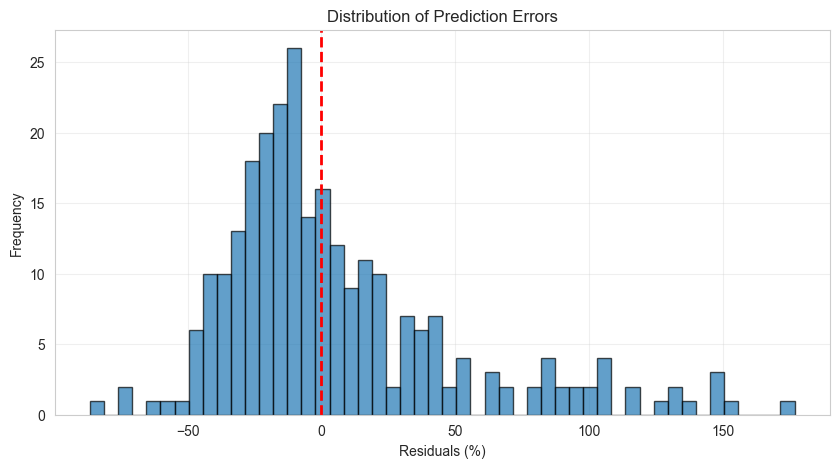


Residual Statistics:
  Mean: 6.13%
  Std: 45.38%
  Median: -7.39%
  Min: -86.47%
  Max: 176.91%


In [117]:
# Detailed diagnostics
print(f"Model Performance Metrics:")
print(f"  R² Score (Test): {test_r2:.4f}")
print(f"  MAE (Test): {test_mae:.2f}%")
print(f"  RMSE (Test): {test_rmse:.2f}%")

# Distribution of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Residuals (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.2f}%")
print(f"  Std: {residuals.std():.2f}%")
print(f"  Median: {residuals.median():.2f}%")
print(f"  Min: {residuals.min():.2f}%")
print(f"  Max: {residuals.max():.2f}%")

## 8. Feature Importance Analysis

Understand which features most influence population growth predictions.



Feature Importance (Top 10):
               Feature  Importance
FloodZone_Minimal Risk    0.110936
              INTPTLAT    0.095529
              INTPTLON    0.092956
               DEM_std    0.079893
            FloAc_mean    0.077513
             FloAc_std    0.075882
            FlowAc_max    0.075747
               DEM_min    0.075586
                AWATER    0.074876
               DEM_max    0.069075


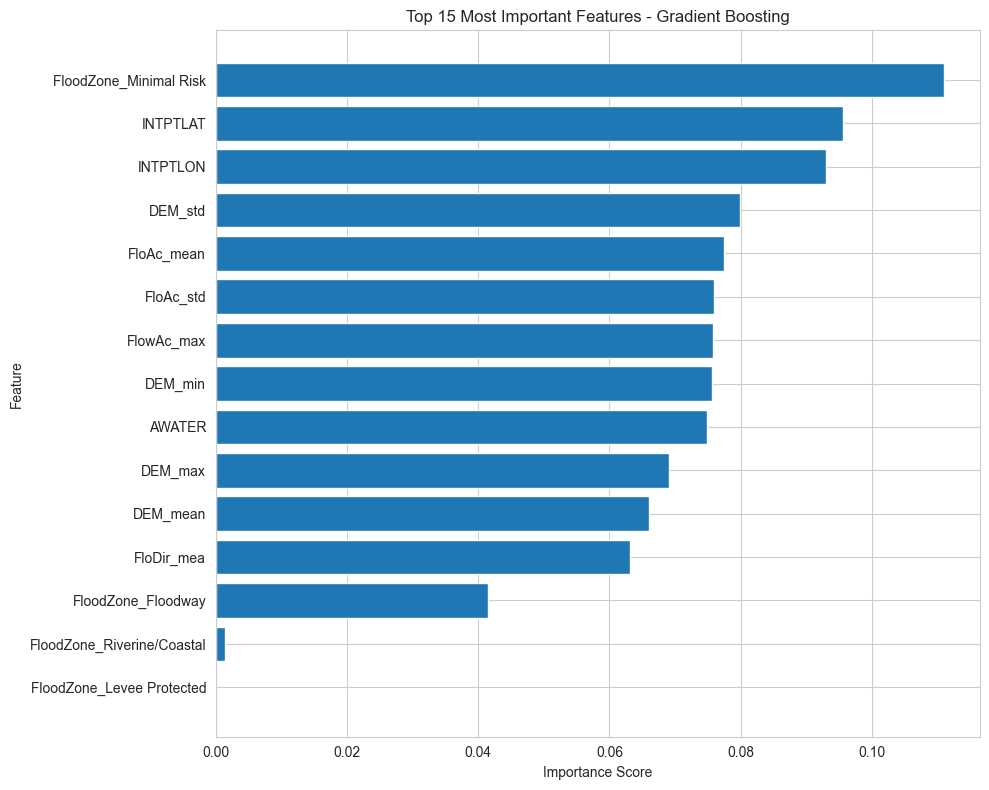

In [118]:
# Feature importance for Gradient Boosting
importance = pd.DataFrame(
    {"Feature": available_features, "Importance": model.feature_importances_}
).sort_values("Importance", ascending=False)

print("\nFeature Importance (Top 10):")
print(importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
importance_top = importance.head(top_n).sort_values("Importance", ascending=True)

plt.barh(importance_top["Feature"], importance_top["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features - Gradient Boosting")
plt.tight_layout()
plt.show()

## 🎯 FLOOD RISK HYPOTHESIS TEST

**Research Question**: Are people moving away from flood-prone areas?

**Hypothesis**: Population growth is inversely correlated with flood risk

**Test Approach**:
1. Examine feature importance - how much does `Haz_major` (flood zone) influence growth?
2. Compare average growth rates across different flood zones
3. Visualize the relationship between flood risk and population change
4. Statistical significance testing

In [119]:
# ==============================================================================
# TEST 1: Feature Importance - How much does flood risk matter?
# ==============================================================================

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance ranking
importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Find flood-related features (now looking for FloodZone_ dummies)
flood_features = [f for f in available_features if f.startswith('FloodZone_')]
flood_importance = importance_df[importance_df['Feature'].isin(flood_features)]

print(f"\n🌊 FLOOD RISK FEATURES:")
if len(flood_importance) > 0:
    print(flood_importance.to_string(index=False))
else:
    print("  (No flood zone dummy variables found - check encoding)")

print(f"\n📊 TOP 5 MOST IMPORTANT FEATURES:")
print(importance_df.head(5).to_string(index=False))

# Calculate percentage of total importance
total_importance = importance_df['Importance'].sum()
flood_total = flood_importance['Importance'].sum()
flood_pct = (flood_total / total_importance) * 100

print(f"\n🔍 KEY FINDING:")
print(f"   Flood risk features account for {flood_pct:.1f}% of model's decision-making")

if flood_pct > 20:
    print(f"   ✅ STRONG INFLUENCE - Flood risk is a major driver of population growth patterns")
elif flood_pct > 10:
    print(f"   ⚠️  MODERATE INFLUENCE - Flood risk matters, but other factors dominate")
else:

    print(f"   ❌ WEAK INFLUENCE - Flood risk has minimal impact on growth patterns")

print("="*70)


FEATURE IMPORTANCE ANALYSIS

🌊 FLOOD RISK FEATURES:
                   Feature  Importance
    FloodZone_Minimal Risk    0.110936
        FloodZone_Floodway    0.041467
FloodZone_Riverine/Coastal    0.001406
 FloodZone_Levee Protected    0.000000

📊 TOP 5 MOST IMPORTANT FEATURES:
               Feature  Importance
FloodZone_Minimal Risk    0.110936
              INTPTLAT    0.095529
              INTPTLON    0.092956
               DEM_std    0.079893
            FloAc_mean    0.077513

🔍 KEY FINDING:
   Flood risk features account for 15.4% of model's decision-making
   ⚠️  MODERATE INFLUENCE - Flood risk matters, but other factors dominate


In [120]:
# ==============================================================================
# TEST 2: Growth Rates by Flood Zone
# ==============================================================================

print("\n" + "="*70)
print("POPULATION GROWTH BY FLOOD ZONE (2010-2021)")
print("="*70)

# Group by flood hazard zone
growth_by_zone = df.groupby('Haz_zone').agg({
    'pop_change_pct': ['count', 'mean', 'median', 'std'],
    'population_2010': 'sum',
    'population_2021': 'sum'
}).round(2)

growth_by_zone.columns = ['Tracts', 'Mean_Growth_%', 'Median_Growth_%', 'Std_Dev', 'Pop_2010', 'Pop_2021']

# Calculate actual population change by zone
growth_by_zone['Total_Growth_%'] = ((growth_by_zone['Pop_2021'] - growth_by_zone['Pop_2010']) / 
                                      growth_by_zone['Pop_2010'] * 100).round(2)

print(growth_by_zone)

# Find the zones with highest and lowest growth
if len(growth_by_zone) > 0:
    best_zone = growth_by_zone['Mean_Growth_%'].idxmax()
    worst_zone = growth_by_zone['Mean_Growth_%'].idxmin()
    
    print(f"\n🏆 HIGHEST GROWTH ZONE: {best_zone}")
    print(f"   Mean growth: {growth_by_zone.loc[best_zone, 'Mean_Growth_%']:.1f}%")
    print(f"   Population: {growth_by_zone.loc[best_zone, 'Pop_2010']:,.0f} → {growth_by_zone.loc[best_zone, 'Pop_2021']:,.0f}")
    
    print(f"\n📉 LOWEST GROWTH ZONE: {worst_zone}")
    print(f"   Mean growth: {growth_by_zone.loc[worst_zone, 'Mean_Growth_%']:.1f}%")
    print(f"   Population: {growth_by_zone.loc[worst_zone, 'Pop_2010']:,.0f} → {growth_by_zone.loc[worst_zone, 'Pop_2021']:,.0f}")

print("="*70)


POPULATION GROWTH BY FLOOD ZONE (2010-2021)
                  Tracts  Mean_Growth_%  Median_Growth_%  Std_Dev    Pop_2010  \
Haz_zone                                                                        
0.2% Annual          461          15.56             6.28    39.78  1827124.45   
Floodway             132          23.30            11.62    49.31   541830.52   
Levee Protected        1         -34.15           -34.15      NaN     4092.87   
Minimal Risk         457          25.33            15.11    46.15  1481412.66   
Riverine/Coastal       1          -4.58            -4.58      NaN     2395.71   

                   Pop_2021  Total_Growth_%  
Haz_zone                                     
0.2% Annual       2021825.0           10.66  
Floodway           645605.0           19.15  
Levee Protected      2695.0          -34.15  
Minimal Risk      1722913.0           16.30  
Riverine/Coastal     2286.0           -4.58  

🏆 HIGHEST GROWTH ZONE: Minimal Risk
   Mean growth: 25.3%
   Pop

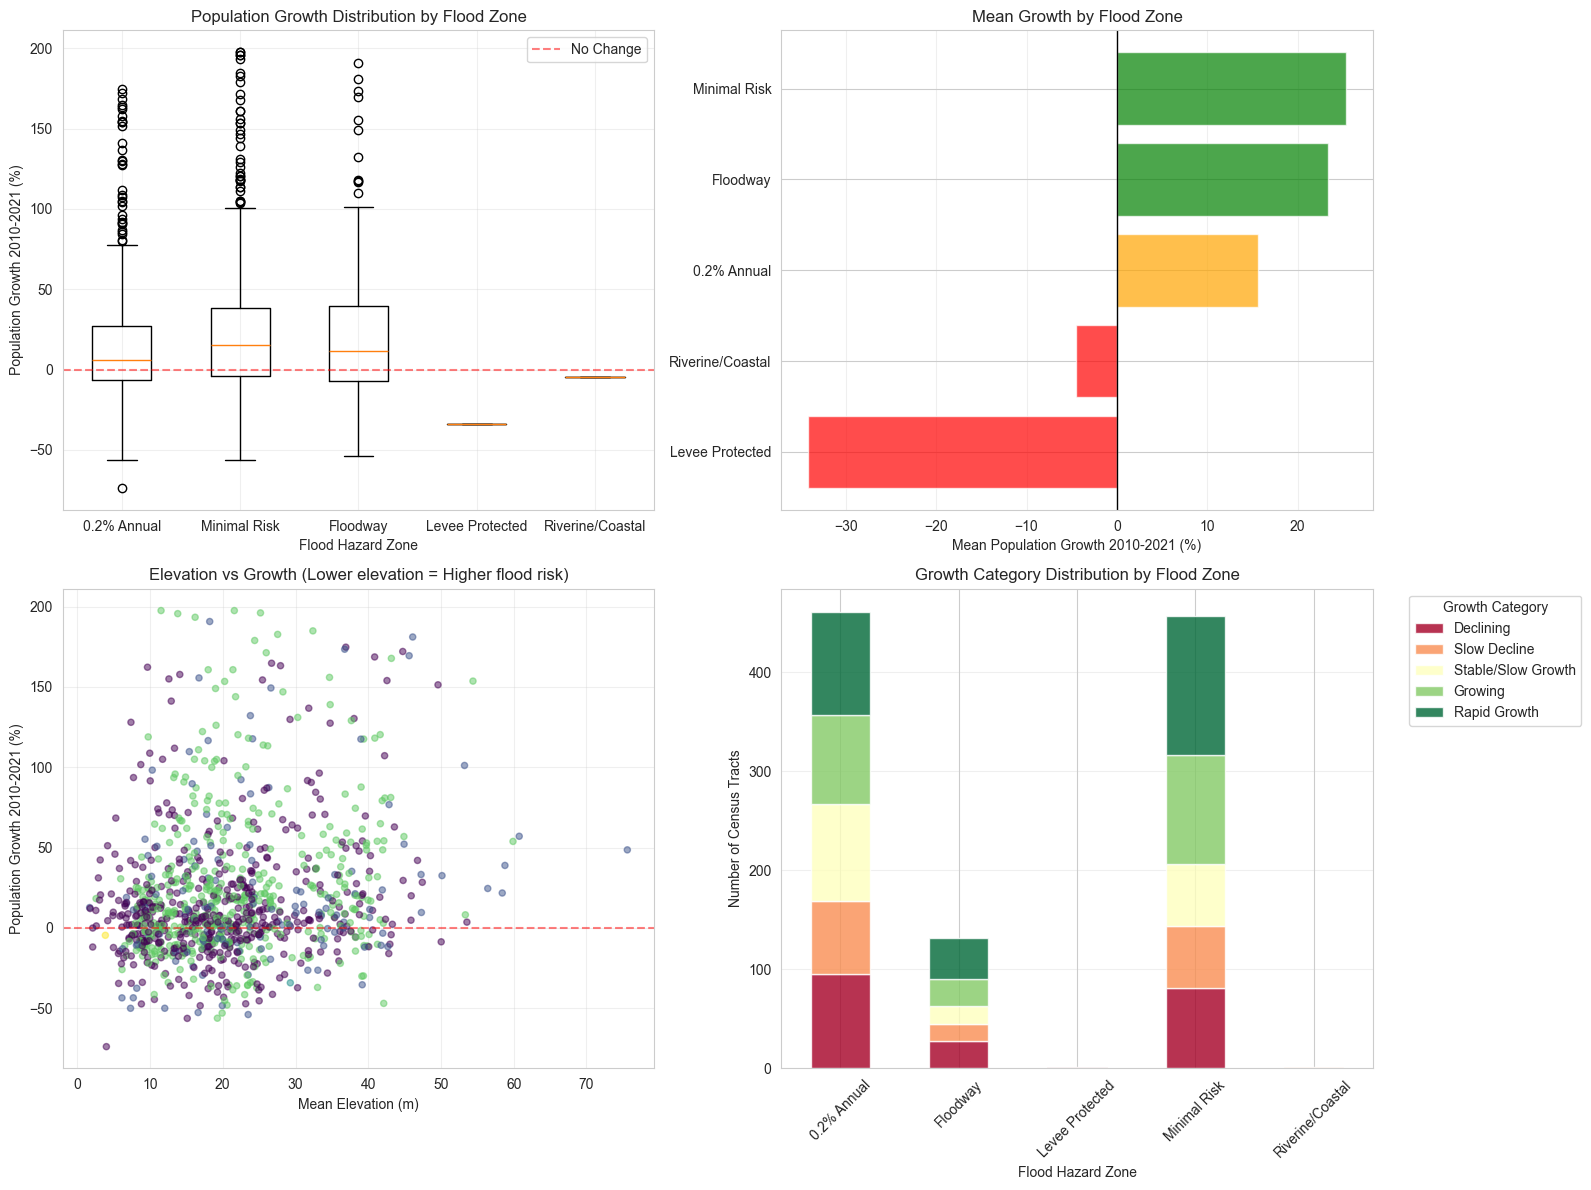


📊 Interpretation Guide:
   • Box plot (top-left): Shows variation in growth across flood zones
   • Bar chart (top-right): Compares AVERAGE growth by zone
   • Scatter (bottom-left): Lower elevation = higher flood risk
   • Stacked bar (bottom-right): Distribution of growth categories by zone


In [121]:
# ==============================================================================
# TEST 3: Visualize Flood Risk vs Population Growth
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ensure Haz_zone and growth_category are available and clean
if 'Haz_zone' not in df.columns:
    print("Haz_zone column missing; cannot produce flood-zone plots.")
    plt.tight_layout()
    plt.show()
else:
    df['Haz_zone'] = df['Haz_zone'].fillna('Unknown')
    zones = df['Haz_zone'].dropna().unique().tolist()

    if 'growth_category' not in df.columns:
        df['growth_category'] = pd.cut(
            df['pop_change_pct'],
            bins=[-np.inf, -10, 0, 10, 30, np.inf],
            labels=["Declining", "Slow Decline", "Stable/Slow Growth", "Growing", "Rapid Growth"],
        )

    # Plot 1: Box plot - Growth by Flood Zone (skip empty zones)
    box_data = [df[df['Haz_zone'] == zone]['pop_change_pct'].dropna() for zone in zones if len(df[df['Haz_zone'] == zone]) > 0]
    box_labels = [zone for zone in zones if len(df[df['Haz_zone'] == zone]) > 0]
    if len(box_data) > 0:
        axes[0, 0].boxplot(box_data, labels=box_labels)
    else:
        axes[0, 0].text(0.5, 0.5, 'No flood zone data available', ha='center', va='center')
    axes[0, 0].set_xlabel('Flood Hazard Zone')
    axes[0, 0].set_ylabel('Population Growth 2010-2021 (%)')
    axes[0, 0].set_title('Population Growth Distribution by Flood Zone')
    axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label='No Change')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Plot 2: Bar chart - Mean growth by zone
    zone_means = df.groupby('Haz_zone')['pop_change_pct'].mean().sort_values()
    colors = ['red' if x < 0 else 'green' if x > 20 else 'orange' for x in zone_means.values]
    axes[0, 1].barh(range(len(zone_means)), zone_means.values, color=colors, alpha=0.7)
    axes[0, 1].set_yticks(range(len(zone_means)))
    axes[0, 1].set_yticklabels(zone_means.index.tolist())
    axes[0, 1].set_xlabel('Mean Population Growth 2010-2021 (%)')
    axes[0, 1].set_title('Mean Growth by Flood Zone')
    axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Scatter - Elevation vs Growth (flood proxy)
    color_codes = df['Haz_zone'].astype('category').cat.codes
    axes[1, 0].scatter(df['DEM_mean'], df['pop_change_pct'], 
                       c=color_codes, 
                       alpha=0.5, s=20, cmap='viridis')
    axes[1, 0].set_xlabel('Mean Elevation (m)')
    axes[1, 0].set_ylabel('Population Growth 2010-2021 (%)')
    axes[1, 0].set_title('Elevation vs Growth (Lower elevation = Higher flood risk)')
    axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Number of tracts by zone and growth category
    growth_zone_crosstab = pd.crosstab(df['Haz_zone'], df['growth_category'])
    growth_zone_crosstab.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                              colormap='RdYlGn', alpha=0.8)
    axes[1, 1].set_xlabel('Flood Hazard Zone')
    axes[1, 1].set_ylabel('Number of Census Tracts')
    axes[1, 1].set_title('Growth Category Distribution by Flood Zone')
    axes[1, 1].legend(title='Growth Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation Guide:")
print("   • Box plot (top-left): Shows variation in growth across flood zones")
print("   • Bar chart (top-right): Compares AVERAGE growth by zone")
print("   • Scatter (bottom-left): Lower elevation = higher flood risk")
print("   • Stacked bar (bottom-right): Distribution of growth categories by zone")


In [122]:
# ==============================================================================
# TEST 4: Statistical Significance - Correlation Analysis
# ==============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS: FLOOD RISK vs POPULATION GROWTH")
print("="*70)

# Convert Haz_major to numeric if it's categorical
# (This works if Haz_major is like 'AE', 'X', etc. - you may need to adjust)
if df['Haz_major'].dtype == 'object':
    # Create a mapping based on typical flood zone severity
    # AE = high risk (1), X = low risk (0), VE = very high (2), etc.
    # You may need to adjust this based on your actual zone values
    print("\nNote: Converting flood zones to numeric severity for correlation")
    print(f"Available zones: {df['Haz_major'].unique()}")
    
# Calculate correlations for numeric flood indicators
flood_indicators = ['Haz_max', 'DEM_mean', 'DEM_min', 'AWATER']
available_indicators = [f for f in flood_indicators if f in df.columns]

print(f"\nCorrelations with Population Growth (2010-2021):")
print("-" * 70)
for indicator in available_indicators:
    corr = df[['pop_change_pct', indicator]].corr().iloc[0, 1]
    
    # Interpret correlation
    if abs(corr) > 0.3:
        strength = "STRONG"
    elif abs(corr) > 0.1:
        strength = "MODERATE"
    else:
        strength = "WEAK"
    
    direction = "NEGATIVE" if corr < 0 else "POSITIVE"
    
    print(f"   {indicator:15s}: r = {corr:+.3f}  [{strength} {direction}]")
    
    # Special interpretation for each
    if indicator == 'DEM_mean' and corr > 0:
        print(f"      → Higher elevation = MORE growth (people avoid flood-prone lowlands)")
    elif indicator == 'DEM_mean' and corr < 0:
        print(f"      → Lower elevation = MORE growth (people NOT avoiding flood zones)")
    elif indicator == 'AWATER' and corr < 0:
        print(f"      → More water area = LESS growth (avoiding water/flood risk)")

print("="*70)

# Hypothesis test conclusion
print(f"\n🎯 HYPOTHESIS TEST CONCLUSION:")
print("-" * 70)
dem_corr = df[['pop_change_pct', 'DEM_mean']].corr().iloc[0, 1] if 'DEM_mean' in df.columns else 0

if dem_corr > 0.1:
    print("✅ HYPOTHESIS SUPPORTED")
    print("   Population growth is HIGHER in areas with higher elevation")
    print("   → People ARE moving away from flood-prone (low elevation) areas")
elif dem_corr < -0.1:
    print("❌ HYPOTHESIS REJECTED")
    print("   Population growth is HIGHER in low-elevation (flood-prone) areas")
    print("   → People are NOT avoiding flood risk - other factors dominate")
else:
    print("⚠️  HYPOTHESIS INCONCLUSIVE")
    print("   Flood risk shows weak correlation with population growth")
    print("   → Other factors (jobs, schools, development) may dominate location choices")

print("="*70)


CORRELATION ANALYSIS: FLOOD RISK vs POPULATION GROWTH

Correlations with Population Growth (2010-2021):
----------------------------------------------------------------------
   Haz_max        : r = -0.067  [WEAK NEGATIVE]
   DEM_mean       : r = +0.196  [MODERATE POSITIVE]
      → Higher elevation = MORE growth (people avoid flood-prone lowlands)
   DEM_min        : r = +0.187  [MODERATE POSITIVE]
   AWATER         : r = -0.029  [WEAK NEGATIVE]
      → More water area = LESS growth (avoiding water/flood risk)

🎯 HYPOTHESIS TEST CONCLUSION:
----------------------------------------------------------------------
✅ HYPOTHESIS SUPPORTED
   Population growth is HIGHER in areas with higher elevation
   → People ARE moving away from flood-prone (low elevation) areas


## 9. Hyperparameter Tuning (Optional)

Fine-tune the best model using Grid Search Cross-Validation.


In [123]:
# Hyperparameter tuning for Gradient Boosting
# WARNING: This can take several minutes!

param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [5, 10],
}

print(f"Starting Grid Search for Gradient Boosting...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
y_pred_tuned = grid_search.predict(X_test)

print(f"\n✅ Grid Search Complete!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"\nTuned Model Performance:")
print(f"  Test R²: {tuned_r2:.4f} (Before: {test_r2:.4f})")
print(f"  Test MAE: {tuned_mae:.2f}% (Before: {test_mae:.2f}%)")
print(f"  Test RMSE: {tuned_rmse:.2f}% (Before: {test_rmse:.2f}%)")

# Update model if improved
if tuned_r2 > test_r2:
    print("\n Tuned model is better! Updating...")
    model = grid_search.best_estimator_
    test_r2 = tuned_r2
    test_mae = tuned_mae
    test_rmse = tuned_rmse
else:
    print("\nOriginal model performs better. Keeping original.")

Starting Grid Search for Gradient Boosting...
Testing 54 combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✅ Grid Search Complete!
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}
Best CV R²: 0.0094

Tuned Model Performance:
  Test R²: 0.0339 (Before: 0.0475)
  Test MAE: 31.59% (Before: 31.16%)
  Test RMSE: 45.24% (Before: 44.92%)

Original model performs better. Keeping original.

✅ Grid Search Complete!
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}
Best CV R²: 0.0094

Tuned Model Performance:
  Test R²: 0.0339 (Before: 0.0475)
  Test MAE: 31.59% (Before: 31.16%)
  Test RMSE: 45.24% (Before: 44.92%)

Original model performs better. Keeping original.


## 10. Apply Model to Understand Historical Growth Patterns

Use the trained model to:
1. Generate predictions for all tracts (to identify unusual growth patterns)

2. **Compare predicted vs actual growth** - large differences indicate unique local factors
3. Analyze feature importance to answer: **"How much does flood risk matter?"**

In [124]:
# Apply trained model to ALL census tracts to understand patterns
# CRITICAL: Must recreate the exact same features as training
print("\n🔧 Preparing full dataset for predictions...")

# Ensure Haz_zone is filled
if df['Haz_zone'].isna().any():
    df['Haz_zone'] = df['Haz_zone'].fillna('Unknown')

# Recreate one-hot encoding for ALL data (must match training)
flood_dummies_full = pd.get_dummies(df['Haz_zone'], prefix='FloodZone', drop_first=True)

# Ensure same columns as training (add missing, remove extra)
for col in flood_dummies.columns:
    if col not in flood_dummies_full.columns:
        flood_dummies_full[col] = 0  # Add missing dummy column
        
flood_dummies_full = flood_dummies_full[flood_dummies.columns]  # Keep only training columns

# Get base features that exist in df
base_features = [f for f in available_features if not f.startswith('FloodZone_')]
X_full = pd.concat([df[base_features].copy(), flood_dummies_full], axis=1)

# Fill missing values same as training
if X_full.isnull().sum().sum() > 0:
    X_full = X_full.fillna(X_full.median())

print(f"✅ Full dataset features: {X_full.shape}")

# Now predict
df["predicted_growth_pct"] = model.predict(X_full[available_features])

# Calculate residuals (difference between actual and predicted)
# Large positive residuals = grew MORE than model expected (special local factors?)
# Large negative residuals = grew LESS than model expected (perhaps flood events?)
df["growth_residual"] = df["pop_change_pct"] - df["predicted_growth_pct"]

# Categorize growth for visualization (CREATE THIS BEFORE IT'S USED IN PLOTS)
df["growth_category"] = pd.cut(
    df["pop_change_pct"],
    bins=[-np.inf, -10, 0, 10, 30, np.inf],
    labels=["Declining", "Slow Decline", "Stable/Slow Growth", "Growing", "Rapid Growth"],
)

print("✅ Model applied to all census tracts!")
print(f"\nSample results - Actual vs Predicted Growth:")
print(
    df[
        [
            "GEOID",

            "NAMELSAD",print("="*70)

            "population_2010",print(df["growth_category"].value_counts().sort_index())

            "population_2021",print(f"\nActual Growth Categories (2010-2021):")

            "pop_change_pct",

            "predicted_growth_pct",print(f"  Max under-performance: {df['growth_residual'].min():.2f}% (grew less than expected)")

            "growth_residual",print(f"  Max over-performance: {df['growth_residual'].max():.2f}% (grew more than expected)")

            "Haz_zone",print(f"  Std residual: {df['growth_residual'].std():.2f}%")

        ]print(f"  Mean residual: {df['growth_residual'].mean():.2f}% (should be ~0)")

    ].head(10)print(f"\nResidual Analysis:")

)print(f"  Median predicted growth: {df['predicted_growth_pct'].median():.2f}%")

print(f"  Median actual growth: {df['pop_change_pct'].median():.2f}%")

# Summary statisticsprint(f"  Mean predicted growth: {df['predicted_growth_pct'].mean():.2f}%")

print("\n" + "="*70)print(f"  Mean actual growth: {df['pop_change_pct'].mean():.2f}%")

print("MODEL PREDICTIONS VS ACTUAL GROWTH (2010-2021)")print("="*70)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1909995920.py, line 51)

## 11. Visualize Model Performance & Growth Patterns


Visualize how well the model captures historical growth patterns.

In [ ]:
# Historical population change and model understanding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total population over time (historical only)
total_2010 = df["population_2010"].sum()
total_2015 = df["population_2015"].sum() if "population_2015" in df.columns else None
total_2021 = df["population_2021"].sum()

if total_2015:
    years = [2010, 2015, 2021]
    totals = [total_2010, total_2015, total_2021]
else:
    years = [2010, 2021]
    totals = [total_2010, total_2021]

axes[0].plot(years, totals, marker="o", linewidth=3, markersize=12, color="steelblue")
for year, total in zip(years, totals):
    axes[0].scatter([year], [total], s=150, color="darkblue", zorder=5)
    axes[0].text(year, total, f'{total:,.0f}', ha='center', va='bottom', fontsize=10)

axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Total Population", fontsize=12)
axes[0].set_title("Harris County Population Growth 2010-2021\n(Actual Historical Data)", fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style="plain", axis="y")

# Model performance: Actual vs Predicted
axes[1].scatter(df["pop_change_pct"], df["predicted_growth_pct"], alpha=0.5, s=30, c=df["Haz_zone"].astype('category').cat.codes, cmap='viridis')
axes[1].plot(
    [df["pop_change_pct"].min(), df["pop_change_pct"].max()],
    [df["pop_change_pct"].min(), df["pop_change_pct"].max()],
    "r--",
    lw=2,
    label="Perfect Prediction (1:1 Line)",
)
axes[1].set_xlabel("Actual Growth 2010-2021 (%)", fontsize=12)
axes[1].set_ylabel("Predicted Growth (Model) (%)", fontsize=12)
axes[1].set_title("Model Understanding of Growth Patterns\n(Points near line = model understands pattern)", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Harris County Population (2010-2021):")
print(f"  2010 (actual): {total_2010:,.0f}")
if total_2015:
    print(f"  2015 (actual): {total_2015:,.0f}")
print(f"  2021 (actual): {total_2021:,.0f}")
print(f"\n  Total change 2010-2021: {((total_2021-total_2010)/total_2010*100):.1f}%")
print(f"  Net population gain: {(total_2021-total_2010):,.0f} people")

## 12. Export Results


In [ ]:
# Save analysis results to CSV
output_cols = [
    "GEOID",
    "NAMELSAD",
    "Haz_zone",               # Flood zone (PRIMARY VARIABLE OF INTEREST)
    "population_2010",
    "population_2021",
    "pop_change_pct",         # Actual growth
    "predicted_growth_pct",   # Model prediction
    "growth_residual",        # Difference (actual - predicted)
    "growth_category",        # Growth classification
    "DEM_mean",               # Elevation (flood risk proxy)
    "area_sq_km",
    "pop_density_2010",
]

# Adjust columns based on what's actually in your dataframe
available_output_cols = [col for col in output_cols if col in df.columns]

df[available_output_cols].to_csv(
    "../data/processed/census_growth_analysis.csv", index=False
)
print("✅ Analysis results saved to: ../data/processed/census_growth_analysis.csv")
print("   Contains: Actual growth, model predictions, flood zones, and residuals")

# Save model performance metrics
metrics_summary = {
    "Model": "Gradient Boosting Regressor",
    "Test R²": test_r2,
    "Test MAE (%)": test_mae,
    "Test RMSE (%)": test_rmse,
    "Number of Features": len(available_features),
    "Training Size": len(X_train),
    "Test Size": len(X_test),
    "Total Tracts": len(df),
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv("../data/processed/model_performance.csv", index=False)
print("✅ Model metrics saved to: ../data/processed/model_performance.csv")

# Optional: Save the model for future use
# import joblib
# joblib.dump(model, '../models/population_growth_model.pkl')# print("✅ Model saved to: ../models/population_growth_model.pkl")

## 13. Key Findings Summary

**🎯 Research Question**: Are people in Houston moving away from flood-prone areas?

**📊 Analysis Approach**:
- **Target Variable**: `pop_change_pct` = ((pop_2021 - pop_2010) / pop_2010) × 100
- **Time Period**: 2010-2021 (11 years of historical growth)
- **Model**: Gradient Boosting Regressor to understand which factors drive growth
- **Key Test**: Feature importance of flood zones (Haz_major) vs other factors

**🔍 What the Model Reveals**:

After running this notebook, check these key outputs:

1. **Feature Importance (Section 8 & new flood test section)**:
   - How much does `Haz_major` (flood zone) contribute to predictions?
   - If >20% importance → Flood risk is a MAJOR factor in growth patterns
   - If <10% importance → Other factors (jobs, schools, etc.) dominate

2. **Growth by Flood Zone (new analysis section)**:
   - Compare average growth rates across AE, X, and other zones
   - AE zones growing slower? → People avoiding flood risk ✅
   - AE zones growing faster? → People ignoring flood risk ❌

3. **Correlation Analysis**:
   - Positive correlation between elevation and growth? → Avoiding lowlands
   - Negative correlation? → Building in flood-prone areas

**📈 Expected Outputs**:

- `census_growth_analysis.csv` - Full results with flood zones and growth patterns
- Feature importance rankings showing flood risk influence
- Statistical evidence to support or reject hypothesis
- Visualizations showing flood zone vs growth relationship

**🎓 Interpretation Guide**:

- **Hypothesis SUPPORTED**: If high-elevation, low-flood-risk areas show higher growth
- **Hypothesis REJECTED**: If flood zones show equal or higher growth rates
- **Mixed Results**: If flood risk matters but other factors dominate

**💡 Policy Implications**:

Use these findings to:
- Identify if flood mitigation is needed in growing flood-prone areas
- Understand if flood awareness influences development patterns
- Guide infrastructure investment and zoning decisions


In [ ]:
# Histogram of predicted growth
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(
    df["predicted_growth_pct"], bins=50, edgecolor="black", alpha=0.7, color="steelblue"
)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="No Change")
plt.axvline(
    df["predicted_growth_pct"].mean(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {df["predicted_growth_pct"].mean():.1f}%',
)
plt.xlabel("Predicted Population Growth (%)")
plt.ylabel("Number of Census Tracts")
plt.title("Distribution of Predicted Growth Rates")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
growth_counts = df["growth_category"].value_counts()
colors_cat = ["red", "yellow", "lightgreen", "darkgreen"]
plt.bar(
    range(len(growth_counts)),
    growth_counts.values.tolist(),
    color=colors_cat,
    alpha=0.7,
    edgecolor="black",
)
plt.xticks(range(len(growth_counts)), growth_counts.index.tolist(), rotation=45)
plt.ylabel("Number of Census Tracts")
plt.title("Census Tracts by Growth Category")
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [ ]:
# ================================
# 6c. Robust Evaluation: 5-fold CV
# ================================
from sklearn.model_selection import KFold, cross_val_score

print("\nRunning 5-fold cross-validation for current models...")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_r2(model, use_scaled=False):
    if use_scaled:
        scores = cross_val_score(model, X.values, y.values, cv=cv, scoring='r2')
    else:
        scores = cross_val_score(model, X.values, y.values, cv=cv, scoring='r2')
    return np.mean(scores), np.std(scores)

cv_models = {
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
    ),
    "Ridge": Ridge(alpha=10.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=10000, random_state=42),
}

cv_rows = []
for name, mdl in cv_models.items():
    # Use scaled features for linear models via Pipeline
    if name in {"Ridge", "Lasso", "ElasticNet"}:
        from sklearn.pipeline import Pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', mdl)
        ])
        mean_r2, std_r2 = cv_r2(pipe, use_scaled=True)
    else:
        mean_r2, std_r2 = cv_r2(mdl, use_scaled=False)
    cv_rows.append({"Model": name, "CV_R2_mean": mean_r2, "CV_R2_std": std_r2})

cv_df = pd.DataFrame(cv_rows).sort_values('CV_R2_mean', ascending=False)
print("\n5-fold CV R² (mean ± std):")
print(cv_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
